## Conformal Prediction for Reliable Decision-Making in AI	

### Farhad Pourkamali 



In [1]:
import numpy as np

def softmax(z):
    """
      Computes the softmax of a numpy array.

      Args:
        z: A numpy array of any shape.

      Returns:
        A numpy array of the same shape as z, with the softmax applied to each row.
    """
    e_z = np.exp(z - np.max(z, axis=-1, keepdims=True))  # For numerical stability
    return e_z / np.sum(e_z, axis=-1, keepdims=True)

# Example usage:
logits = np.array([0.829, 0.136, -0.963])
probs = softmax(logits)
print(probs.round(2)) 

[0.6 0.3 0.1]


In [2]:
import numpy as np
import matplotlib.pyplot as plt 

# Set random seed for reproducibility
np.random.seed(5)

# Generate synthetic data for three-class classification
mean_class_1 = [2, 3]
cov_class_1 = [[1, 0.5], [0.5, 1]]
data_class_1 = np.random.multivariate_normal(mean_class_1, cov_class_1, 200)

mean_class_2 = [6, 5]
cov_class_2 = [[1, -0.5], [-0.5, 1]]
data_class_2 = np.random.multivariate_normal(mean_class_2, cov_class_2, 200)

mean_class_3 = [2, 5]
cov_class_3 = [[1, 0], [0, 1]]
data_class_3 = np.random.multivariate_normal(mean_class_3, cov_class_3, 200)

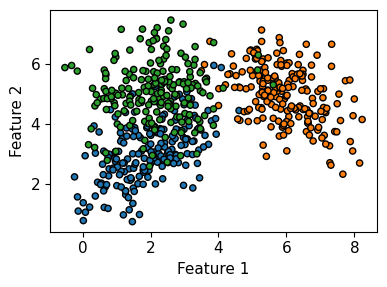

In [3]:
# Combine the three classes into a single dataset
X = np.vstack((data_class_1, data_class_2, data_class_3))
y = np.hstack((np.zeros(200, dtype=int), np.ones(200, dtype=int),
               2 * np.ones(200, dtype=int)))  

# Plot the synthetic data
plt.rcParams.update({'font.size': 11, "figure.figsize": (4,3)})
colors = {0: "#1f77b4", 1: "#ff7f0e", 2:  "#2ca02c"}
y_col = list(map(colors.get, y))

plt.scatter(X[:, 0], X[:, 1], c=y_col, marker='o', s=20, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()

In [4]:
# Divide the data into three sets: training, calibration, and testing 

from sklearn.model_selection import train_test_split


X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=1/3, random_state=42)


X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=1/2, random_state=42)

print(X_train.shape, X_cal.shape, X_test.shape)

(200, 2) (200, 2) (200, 2)


In [5]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_cal)

print(y_prob[:5])

[[8.85126526e-01 3.22633827e-05 1.14841211e-01]
 [7.61893964e-02 5.11431650e-01 4.12378953e-01]
 [6.82677859e-02 2.89546593e-05 9.31703259e-01]
 [1.71800476e-01 9.33127633e-03 8.18868247e-01]
 [8.06669635e-01 4.16252408e-02 1.51705125e-01]]


In [6]:
# Get calibration scores 

n2 = X_cal.shape[0]

cal_scores = 1 - y_prob[np.arange(n2), y_cal]

print(cal_scores[:5])

[0.11487347 0.48856835 0.06829674 0.18113175 0.19333037]


In [7]:
# Get adjusted quantile

def find_quantile(cal_scores, n2, alpha):

    q_level = np.ceil((n2+1)*(1-alpha))/n2

    qhat = np.quantile(cal_scores, q_level, method='higher')
    
    return qhat 

In [8]:
# Plot calibration scores and adjusted quantile for various alpha 

def plot_scores(alphas, cal_scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(5, 3))
    plt.rcParams.update({'font.size': 12})
    plt.hist(cal_scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=150,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}"
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores $s_i$")
    plt.ylabel("Count")
    plt.show()

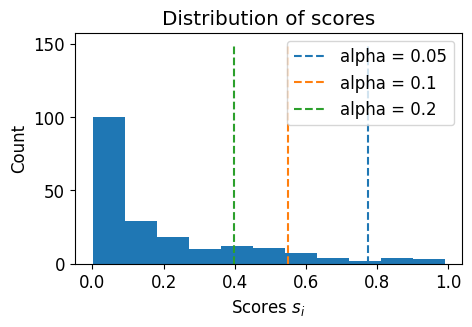

In [9]:
alphas = [0.05, 0.1, 0.2] # error rate 

quantiles = [find_quantile(cal_scores, n2, alpha) for alpha in alphas]

plot_scores(alphas, cal_scores, quantiles)

In [10]:
# Build the prediction set (one alpha only)

qhat = find_quantile(cal_scores, n2, alpha=0.1)

prediction_sets = clf.predict_proba(X_test) >= (1-qhat) 

prediction_sets[:5]

array([[ True, False, False],
       [False, False,  True],
       [ True, False,  True],
       [ True, False, False],
       [False, False,  True]])

In [11]:
# Do we achieve close to 90% coverage?

prediction_sets[np.arange(len(y_test)), y_test].mean()


0.91

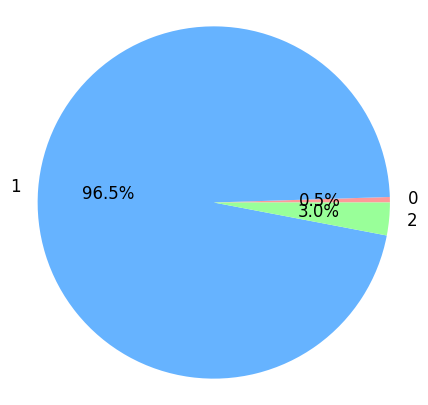

In [12]:
# What about the size of prediction sets? 

sizes = prediction_sets.sum(axis=1)

# Define a color scheme
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']  # Example colors

# Count the occurrences of each category (0, 1, and 2)
unique_categories, counts = np.unique(sizes, return_counts=True)



# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=unique_categories, autopct='%1.1f%%', startangle=0, colors= colors)
#plt.title('Analysis of Prediction Set Size Distribution')
plt.axis('equal')  

plt.show()

### Image Classification with Pretrained Models in PyTorch
<hr style="border:2px solid gray">


* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

* The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size

<img src="cifar.png"  width=600 style="display: block; margin-left: auto; margin-right: auto;">


In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# Define the transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR10 training  dataset
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Define the size of the split (e.g., 70% for training, 30% for calibration)
train_size = int(0.7 * len(train_set))
cal_size = len(train_set) - train_size

# Use random_split to split the dataset into train and test sets
train_subset, cal_subset = random_split(train_set, [train_size, cal_size])

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [14]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=4,
                                          shuffle=True, num_workers=2)

cal_loader = torch.utils.data.DataLoader(cal_subset, batch_size=4,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                          shuffle=True, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


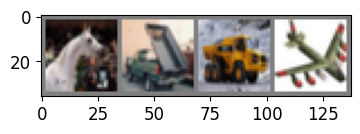

horse truck truck plane


In [15]:
import matplotlib.pyplot as plt
import numpy as np

batch_size = 4
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:3s}' for j in range(batch_size)))


In [16]:
# Define a Convolutional Neural Network

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Train the network ...

In [17]:
# Load the pretrained model 

net = Net()

PATH = './cifar_net.pth'

net.load_state_dict(torch.load(PATH, weights_only=True))

/Users/farhad/anaconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

In [18]:
# Create an empty 1D array
arr = np.array([])

with torch.no_grad():
    for data in cal_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1)  # Apply softmax along the class dimension
        
        # Find scores 
        scores = probabilities[torch.arange(batch_size), labels].numpy()
        
        arr = np.append(arr, scores)

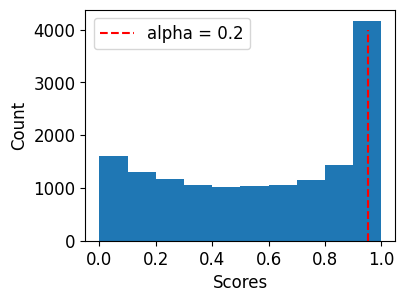

In [19]:
# Find quantile 

plt.hist(arr)
plt.xlabel('Scores')
plt.ylabel('Count')

q_hat = find_quantile(arr, 15000, 0.2)

plt.vlines(
            x=q_hat,
            ymin=0,
            ymax=4000,
            color='red',
            ls="dashed",
            label=f"alpha = {0.2}"
        )

plt.legend()
plt.show()


In [20]:
print(q_hat)

0.9539666175842285


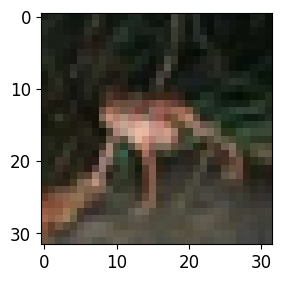

deer
frog


In [21]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show image
imshow(images[0])

# Print prediction set
outputs = net(images[0:1])
probabilities = F.softmax(outputs, dim=1).detach().numpy() 
prediction_sets = probabilities >= (1-q_hat) 

for i in np.where(prediction_sets.ravel()==True)[0]:
    print(classes[i])


In [23]:
classes[labels[0]]

'frog'